# A simple RBC model in sequence space

Let's start from a standard set of equilibrium conditions.

$$
\textbf{H}_t(\textbf{Y}, Z) \equiv 
\begin{pmatrix}
C_t^{-\sigma} - \beta (1 + r_{t+1}) C_{t+1}^{-\sigma}
\\
w_t - \varphi L_t^{\nu} C_t^{\sigma}
\\
K_t - (1 - \delta) K_{t-1} - I_t
\\
r_t + \delta -\alpha Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha-1}
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha}
\\
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
Y_t - C_t - I_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$


## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from simple_block import simple
import jacobian as jac
import nonlinear

## 1 Steady state

In [2]:
def rbc_ss(r=0.01, eis=1, frisch=1, delta=0.025, alpha=0.11):
    """Solve steady state of full GE model."""
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # preference params from HH optimality, numerical for HA version
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    # report variables
    ss = {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
          'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

    return ss

In [3]:
ss = rbc_ss()

## 2 Model blocks
Alternatively, we could make the Euler equation into a SolvedBlock to determine $C$ before targets. This would be closer to how the HA-version works, but clearly a suboptimal choice here. 

In [4]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    I = K - (1 - delta) * K(-1)
    return r, w, Y, I

@simple
def household(L, w, eis, frisch, vphi):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    return C

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    labor_mkt = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)  
    goods_mkt = Y - C - I
    walras = C + K - (1 + r) * K(-1) - w * L # we can check this
    return labor_mkt, goods_mkt, walras

## 3 Linearized solution

In [5]:
T = 300

G = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['labor_mkt', 'goods_mkt'],
              T=T, ss=ss)

# np.max(np.abs(G['walras']['Z']))

Equipped with the `G` matrices, we can get the impulse responses to any shock $dZ$ via matrix multiplication.

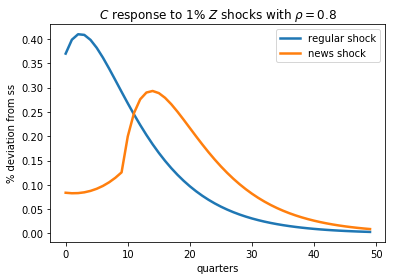

In [6]:
rho, news = 0.8, 10
dZ = np.empty((T, 2))
dZ[:, 0] = 0.01 * ss['Z'] * rho**np.arange(T)
dZ[:, 1] = np.concatenate((np.zeros(news), dZ[:-news, 0])) 

dC = G['C']['Z'] @ dZ / ss['C']

plt.plot(100*dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(100*dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'$C$ response to 1% $Z$ shocks with $\rho=0.8$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

## 4 Nonlinear solution

This is shock-specific of course.

In [7]:
Z = ss['Z'] + 0.01*0.8**np.arange(T)
td_nonlin = nonlinear.td_solve(ss=ss, block_list=[firm, household, mkt_clearing],
                               unknowns=['K', 'L'], targets=['goods_mkt', 'labor_mkt'], Z=Z)

On iteration 0
   max error for goods_mkt is 8.91E-04
   max error for labor_mkt is 2.75E-03
On iteration 1
   max error for goods_mkt is 9.21E-05
   max error for labor_mkt is 4.07E-05
On iteration 2
   max error for goods_mkt is 4.07E-07
   max error for labor_mkt is 4.66E-07
On iteration 3
   max error for goods_mkt is 5.74E-09
   max error for labor_mkt is 5.76E-09


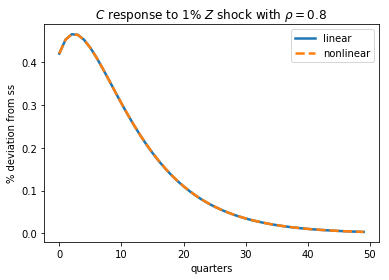

In [8]:
dC_nonlin = td_nonlin['C']/ss['C'] - 1
dC_lin = G['C']['Z'] @ (Z - ss['Z']) / ss['C']
plt.plot(100*dC_lin[:50], label='linear', linewidth=2.5)
plt.plot(100*dC_nonlin[:50], label='nonlinear',  linestyle='--', linewidth=2.5)
plt.title(r'$C$ response to 1% $Z$ shock with $\rho=0.8$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

## 5 Replacing the household block

In [9]:
import hank
import het_block as ha

In [10]:
def bewley_ss(beta_guess=0.97, vphi_guess=1, r=0.01, eis=1, frisch=1, delta=0.025, alpha=0.11,
              rho=0.966, sigma=0.5, nS=7, nA=500, amax=1000):
    """Solve steady state of full GE model."""
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho, sigma=sigma, N=nS)
    T = np.empty_like(e_grid)
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]

    # initial guess for backward variable Va
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = hank.household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, T=T, w=w, r=r, beta=beta_loc, eis=eis,
                                frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc, ssflag=True)
        return np.array([out['A'] - K, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation to report variables
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = hank.household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, T=T, w=w, r=r, beta=beta, eis=eis,
                           frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const, ssflag=True)

    # check Walras's law
    walras = Y - ss['C'] - I
    assert np.abs(walras) < 1E-8

    # report variables
    ss.update({'delta': delta, 'alpha': alpha, 'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'walras': walras})

    return ss

In [11]:
ss2 = bewley_ss()

In [12]:
@simple
def mkt_clearing_ha(K, L, A, NS):
    asset_mkt = A - K
    labor_mkt = NS - L
    return asset_mkt, labor_mkt

G2 = jac.get_G(block_list=[firm, hank.household, mkt_clearing_ha],
               exogenous=['Z'],
               unknowns=['K', 'L'],
               targets=['labor_mkt', 'asset_mkt'],
               T=T, ss=ss2)

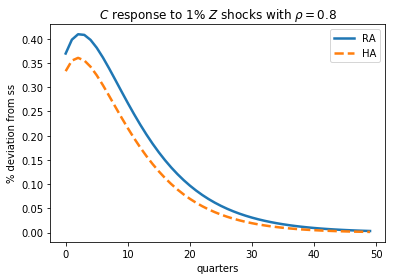

In [16]:
dC2 = G2['C']['Z'] @ dZ / ss2['C']

plt.plot(100*dC[:50, 0], label='RA', linewidth=2.5)
plt.plot(100*dC2[:50, 0], label='HA', linestyle='--', linewidth=2.5)
plt.legend()
plt.title(r'$C$ response to 1% $Z$ shocks with $\rho=0.8$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()